### Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor


### Load and split data

In [4]:

X_train_df = pd.read_csv('./data/X_train.csv',skiprows=1,header=None)
Y_train_df = pd.read_csv('./data/y_train.csv',skiprows=1,header=None)
X_test_df = pd.read_csv('./data/X_test.csv',skiprows=1,header=None)

X_train = X_train_df.iloc[:,1:]
Y_train = Y_train_df.iloc[:,1]
X_test = X_test_df.iloc[:,1:]



### Imputation

In [5]:
median_imputer = SimpleImputer(strategy='median')

X_train_imputed = median_imputer.fit_transform(X_train)

X_test_imputed = median_imputer.transform(X_test)

X_train = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X_test.columns)
print(X_train.shape)


(1212, 832)


### Outlier Detection

/tmp/ipykernel_6879/322203289.py:17: RuntimeWarning: invalid value encountered in divide
  z_scores = np.abs((X_values - X_values.mean(axis=0)) / X_values.std(axis=0))


Nombre d'outliers détectés : 54 sur 1212 (4.46%)
Après suppression des outliers, taille de X_train : (1158, 832)
Après suppression des outliers, taille de Y_train : (1158,)


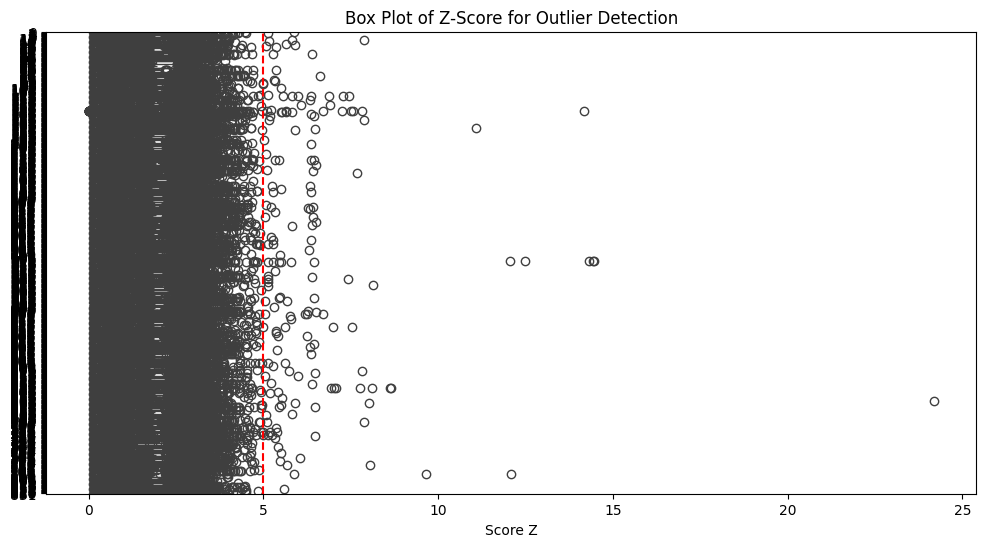

In [7]:

# Définition de la fonction de détection des outliers
def z_score_outliers(X, threshold=3):
    """
    Détecte les outliers en utilisant les scores Z.

    Parameters:
    X (pd.DataFrame ou np.ndarray) : Données d'entrée.
    threshold (float) : Seuil au-delà duquel une valeur est considérée comme un outlier.

    Returns:
    np.ndarray : Tableau booléen indiquant les outliers.
    """
    if isinstance(X, pd.DataFrame):
        X_values = X.values
    else:
        X_values = X
    z_scores = np.abs((X_values - X_values.mean(axis=0)) / X_values.std(axis=0))
    outliers = (z_scores > threshold).any(axis=1)

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=z_scores, orient='h')
    plt.axvline(x=threshold, color='red', linestyle='--')
    plt.xlabel('Score Z')
    plt.title('Box Plot of Z-Score for Outlier Detection')

    return outliers

outliers = z_score_outliers(X_train, threshold=5)

num_outliers = np.sum(outliers)
total_points = X_train.shape[0]
print(f"Nombre d'outliers détectés : {num_outliers} sur {total_points} ({(num_outliers/total_points)*100:.2f}%)")

X_train_clean = X_train[~outliers]
Y_train_clean = Y_train[~outliers]

print(f"Après suppression des outliers, taille de X_train : {X_train_clean.shape}")
print(f"Après suppression des outliers, taille de Y_train : {Y_train_clean.shape}")


## Scaler

In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_clean)

X_test_scaled = scaler.transform(X_test)


### Feature Selection

In [11]:
from sklearn.feature_selection import f_regression
import numpy as np

f_scores, p_values_calc = f_regression(X_train_scaled, Y_train_clean)

p_value_threshold = 0.018  

selected_indices = [i for i, p in enumerate(p_values_calc) if p < p_value_threshold]

X_train_selected = X_train_scaled[:, selected_indices]
X_test_selected = X_test_scaled[:, selected_indices]
X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)



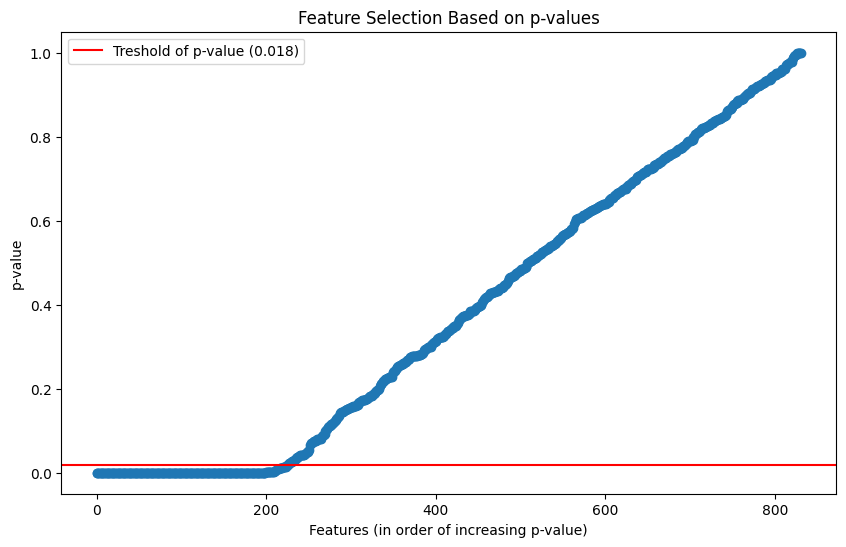

In [12]:
import matplotlib.pyplot as plt

sorted_p_values = np.sort(p_values_calc)
sorted_indices = np.argsort(p_values_calc)

plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_p_values)), sorted_p_values, marker='o')
plt.axhline(y=p_value_threshold, color='r', linestyle='-', label=f'Treshold of p-value ({p_value_threshold})')
plt.xlabel("Features (in order of increasing p-value)")
plt.ylabel("p-value")
plt.title("Feature Selection Based on p-values")
plt.legend()
plt.show()


### MODEL

#### SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],              
    'gamma': [0.001, 0.01, 0.1, 1, 10, 'scale'],     
    'epsilon': [0.001, 0.01, 0.1, 0.5, 1.0],         
    'kernel': ['rbf']                                
}

svm_model = SVR()

grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

grid_search.fit(X_train_sel, y_train)

best_params = grid_search.best_params_
SVRmodel = grid_search.best_estimator_

print("Best parameters:", best_params)

y_val_pred = SVRmodel.predict(X_val_sel)
score = r2_score(y_val, y_val_pred)
print("R² Score with tuned hyperparameters:", score)
print(X_train_selected.shape)
print(X_test_selected.shape)


Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] END .....C=0.01, epsilon=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .....C=0.01, epsilon=0.001, gamma=0.001, kernel=rbf; total time=   0.1s
[CV] END .......C=0.01, epsilon=0.001, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ......C=0.01, epsilon=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END ......C=0.01, epsilon=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......C=0.01, epsilon=0.001, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END ......C=0.01, epsilon=0.001, gamma=0.01, kernel=rbf; total time=   0.1s
[CV] END .......C=0.01, epsilon=0.001, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........C=0.01, epsilon=0.001, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........C=0.01, epsilon=0.001, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....C=0.01, epsilon=0.001, gamma=0.001, kernel=rbf; total time=   0.2s
[CV] END .....C=0.01, epsilon=0.001, gamma=0.0

#### Gradient Boosting Regressor (Not used)

In [13]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)

# param_grid = {
#     'n_estimators': [2500],      
#     'learning_rate': [0.01, 0.1, 0.05],       
#     'max_depth': [3, 5],                    
#     'min_samples_split': [2, 5],           
#     'min_samples_leaf': [1, 2, 5],             
#     'subsample': [0.8],             
#     'max_features': ['sqrt']  
# }

# gb_regressor = GradientBoostingRegressor(random_state=42)

# grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring='r2',verbose=2, n_jobs=-1)

# grid_search.fit(X_train_sel, y_train)

# print("Best parameters found: ", grid_search.best_params_)

# best_gb_regressor = grid_search.best_estimator_

# y_pred = best_gb_regressor.predict(X_val_sel)

# mse = mean_squared_error(y_val, y_pred)
# r2 = r2_score(y_val, y_pred)

# print("Mean Squared Error (MSE) after tuning:", mse)
# print("R-squared (R2) after tuning:", r2)
# print(X_train_selected.shape)
# print(X_test_selected.shape)


#### ExtraTreesRegressor

In [227]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor

X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)
param_grid = {
    'n_estimators': [2500],        
    'max_depth': [ 10, 20, 30],        
    'min_samples_split': [ 2, 5, 10],        
    'min_samples_leaf': [ 1, 2, 4],          
}

extra_forest = ExtraTreesRegressor(random_state=42)
grid_search = GridSearchCV(estimator=extra_forest, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

grid_search.fit(X_train_sel, y_train)

best_params = grid_search.best_params_
print("Meilleurs paramètres:", best_params)

extree = grid_search.best_estimator_

y_pred_tuned = extree.predict(X_val_sel)

r2_tuned = r2_score(y_val, y_pred_tuned)
print("R2 score après tuning:", r2_tuned)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2500; total time=  34.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2500; total time=  37.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=2500; total time=  42.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=2500; total time=  42.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=2500; total time=  42.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=2500; total time=  42.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=2500; total time=  45.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=2500; total time=  48.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=2500; total time=  49.3s
[CV] END max_depth

/home/xian/Bureau/ma1/adv_ml/project_1/Lab1-AML-ETH/venv/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs paramètres: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2500}
R2 score après tuning: 0.5417316212574673


#### XGBoost REGRESSOR

In [229]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [2500],        
    'learning_rate': [0.01, 0.05, 0.1],      
    'max_depth': [3, 5, 7],                  
    'subsample': [0.6, 0.8, 1.0],            
    'colsample_bytree': [0.6, 0.8, 1.0]      
}

xgboost_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring='r2',       
    cv=5,               
    n_jobs=-1,          
    verbose=2           
)

grid_search.fit(X_train_sel, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found:", best_params)
print("Best R2 score from GridSearchCV:", best_score)

xgboost_best = grid_search.best_estimator_
y_pred_best = xgboost_best.predict(X_val_sel)

r2_best = r2_score(y_val, y_pred_best)
print("Optimized R2 score on validation set:", r2_best)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.8; total time=  16.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.8; total time=  16.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.8; total time=  17.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.6; total time=  18.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=1.0; total time=  18.4s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.6; total time=  19.3s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.8; total time=  19.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=2500, subsample=0.6; total time=  19.9s
[C

#### GAUSSIAN PROCESS

In [ ]:


X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)

from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, WhiteKernel, DotProduct
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

kernels = [
    C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2)),
    C(1.0, (1e-3, 1e3)) * Matern(length_scale=1, length_scale_bounds=(1e-2, 1e2), nu=1.5),
    C(1.0, (1e-3, 1e3)) * DotProduct(sigma_0=1),
    C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2)) + WhiteKernel(noise_level=1),
]

gp = GaussianProcessRegressor(n_restarts_optimizer=10, random_state=42)

param_grid = {
    "kernel": kernels
}

scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False), 'R2': make_scorer(r2_score)}
grid_search = GridSearchCV(gp, param_grid, cv=5, scoring=scoring, refit='R2', n_jobs=-1)

grid_search.fit(X_train_sel, y_train)

best_gp = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Meilleur noyau:", best_params)
print("Meilleur score R2 en validation croisée:", best_score)

y_pred, sigma = best_gp.predict(X_val_sel, return_std=True)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print("Mean Squared Error après tuning:", mse)
print("R2 score après tuning:", r2)




/home/xian/Bureau/ma1/adv_ml/project_1/Lab1-AML-ETH/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Meilleur noyau: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Meilleur score R2 en validation croisée: 0.4699714615347633
Mean Squared Error après tuning: 29.707139233100264
R2 score après tuning: 0.6144817323369571


In [ ]:

SVRmodel.fit(X_train_selected, Y_train_clean)
#best_gb_regressor.fit(X_train_selected, Y_train_clean)
xgboost_best.fit(X_train_selected, Y_train_clean)
extree.fit(X_train_selected, Y_train_clean)
best_gp.fit(X_train_selected, Y_train_clean)
print(X_train_selected.shape)
print(X_test_selected.shape)


(1158, 225)
(776, 225)


#### ENSEMBLE

In [233]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train_sel, X_val_sel, y_train, y_val = train_test_split(X_train_selected, Y_train_clean, test_size=0.2, random_state=42)

stacking_model = StackingRegressor(
    estimators=[
        ('extree', extree),
        ('svr', SVRmodel),
        ('gp_optimized', best_gp),
        ('xgboost_best', xgboost_best)
    ],
    final_estimator=RidgeCV(np.arange(1,1000), scoring="r2"),  
    cv=5
)

stacking_model.fit(X_train_selected, Y_train_clean)

y_pred = stacking_model.predict(X_val_sel)
r2 = r2_score(y_val, y_pred)

print("R2 score:", r2)
print("Best alpha for Ridge meta-learner:", stacking_model.final_estimator_.alpha_)

R2 score: 0.9970364968440986
Best alpha for Ridge meta-learner: 412


In [234]:

Y_test = stacking_model.predict(X_test_selected)


Y_test = Y_test.flatten()  

Y_test_df = pd.DataFrame({
    'id': np.arange(len(Y_test)).astype(float),  
    'y': Y_test  
})

Y_test_df.to_csv('./data/sample.csv', index=False)
